<a href="https://colab.research.google.com/github/jaikrishnaads/Appliedai1/blob/main/execise51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

It appears the previous execution was interrupted. I will re-run the entire cell to continue with the experiments.


--- Experiment 1: 80-20 Split ---
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962

ROC-AUC: 0.9800
PR-AUC: 0.7394


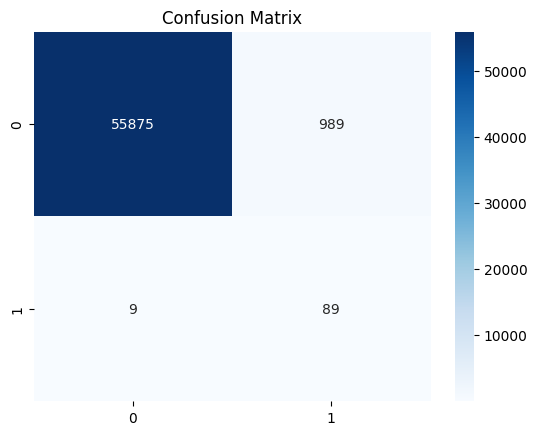

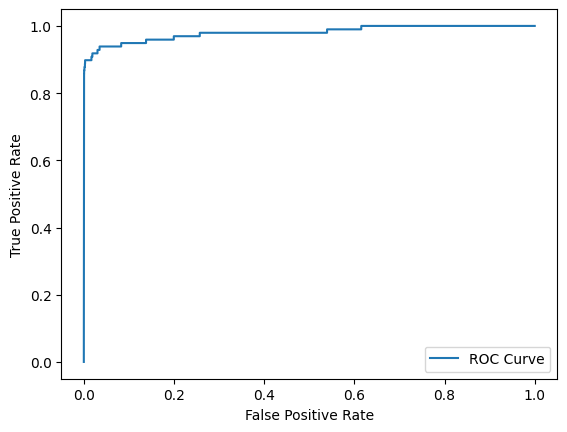

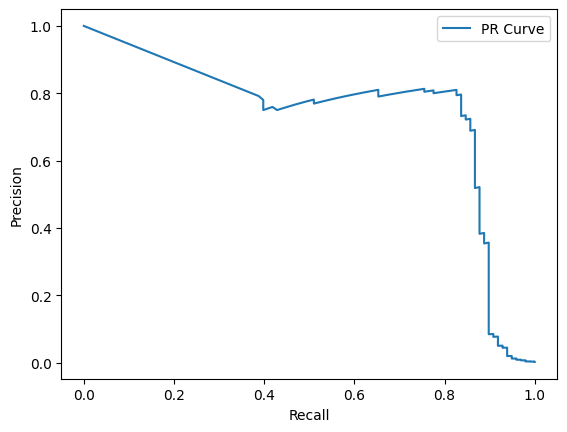


--- Experiment 2: 70-30 Split ---
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.08      0.89      0.14       148

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.57     85443
weighted avg       1.00      0.98      0.99     85443

ROC-AUC: 0.9811
PR-AUC: 0.7083


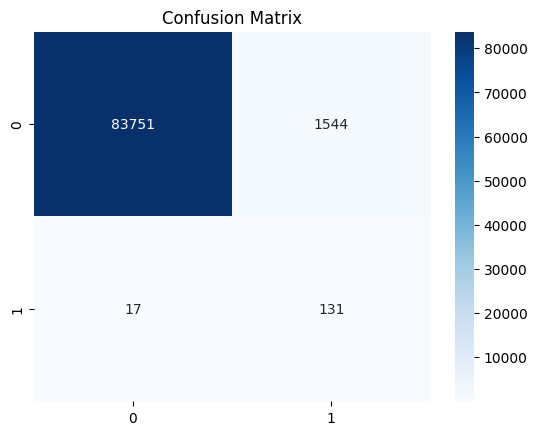

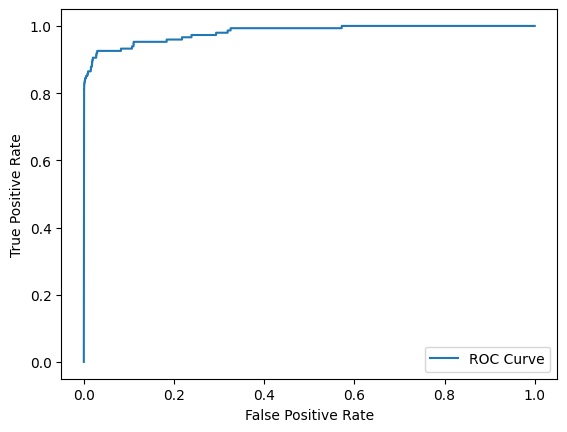

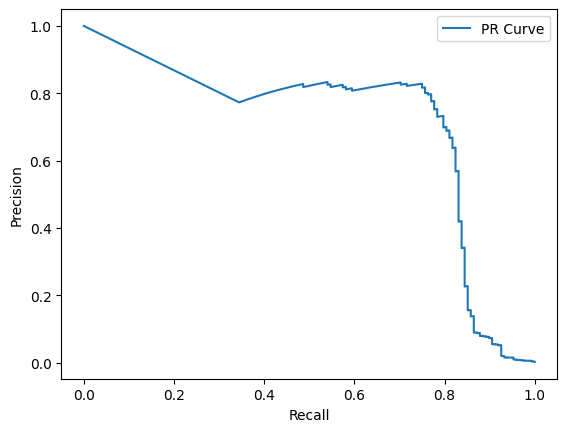


--- Experiment 3: 60-20-20 Split ---
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.12      0.90      0.21        99

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962

ROC-AUC: 0.9781
PR-AUC: 0.7512


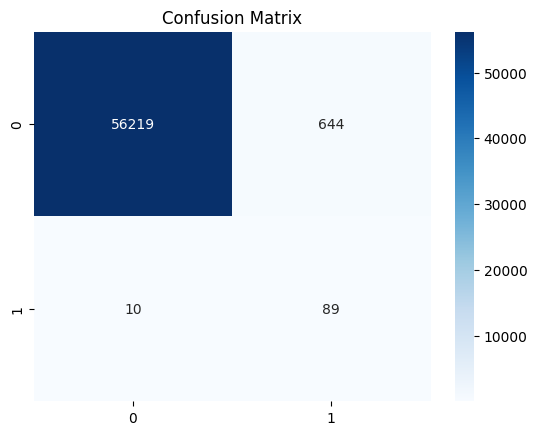

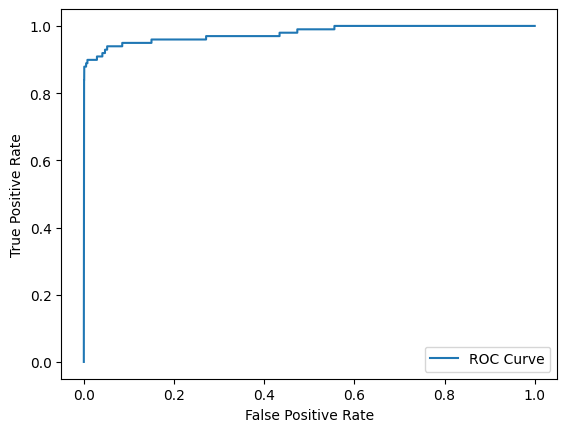

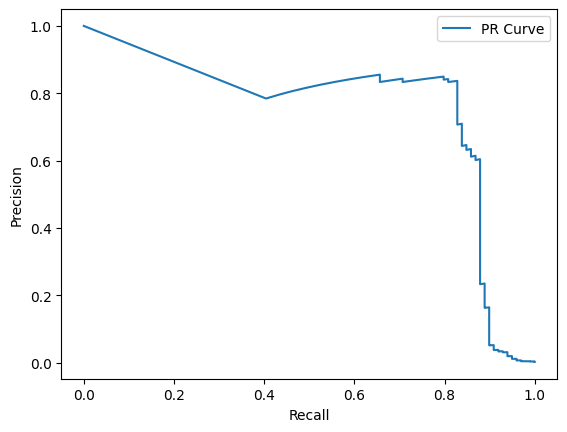


--- Experiment 4: 70-15-15 Split ---
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42648
           1       0.08      0.89      0.14        74

    accuracy                           0.98     42722
   macro avg       0.54      0.94      0.57     42722
weighted avg       1.00      0.98      0.99     42722

ROC-AUC: 0.9874
PR-AUC: 0.7642


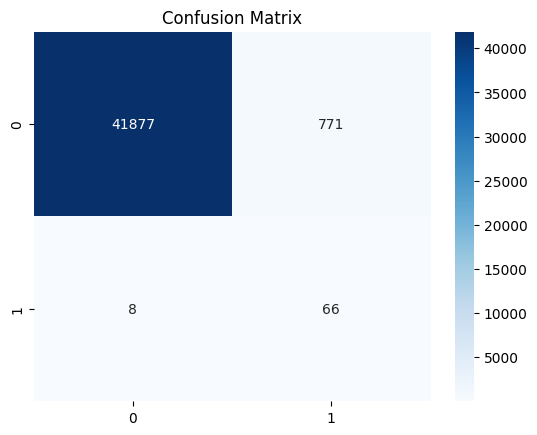

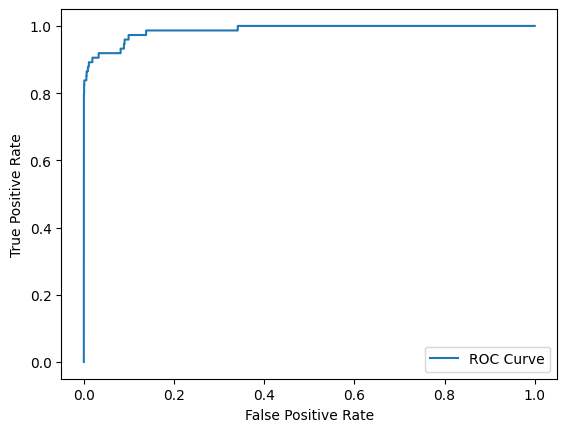

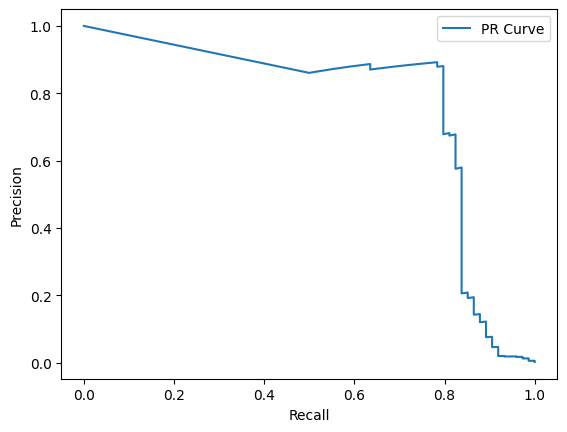


--- 5-Fold Stratified Cross Validation ---
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean ROC-AUC: 0.9813 (+/- 0.0054)
Mean PR-AUC: 0.7666 (+/- 0.0304)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve
)

import tensorflow as tf
from tensorflow.keras import layers, models

url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

X = df.drop('Class', axis=1)
y = df['Class']

neg, pos = np.bincount(y)
total = neg + pos

class_weight = {
    0: (1 / neg) * (total / 2.0),
    1: (1 / pos) * (total / 2.0)
}

def build_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='pr_auc', curve='PR')]
    )

    return model

def evaluate_results(y_true, y_pred_prob):
    y_pred_prob = y_pred_prob.ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_prob):.4f}")

    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    print(f"PR-AUC: {auc(recall, precision):.4f}")

    sns.heatmap(
        confusion_matrix(y_true, y_pred),
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(recall, precision, label='PR Curve')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

print("\n--- Experiment 1: 80-20 Split ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model1 = build_model(X_train.shape[1])
model1.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=2048,
    class_weight=class_weight,
    verbose=0
)

evaluate_results(y_test, model1.predict(X_test))


print("\n--- Experiment 2: 70-30 Split ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

model2 = build_model(X_train.shape[1])
model2.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=2048,
    class_weight=class_weight,
    verbose=0
)

evaluate_results(y_test, model2.predict(X_test))


print("\n--- Experiment 3: 60-20-20 Split ---")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

model3 = build_model(X_train.shape[1])
model3.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    class_weight=class_weight,
    verbose=0
)

evaluate_results(y_test, model3.predict(X_test))


print("\n--- Experiment 4: 70-15-15 Split ---")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

model4 = build_model(X_train.shape[1])
model4.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    class_weight=class_weight,
    verbose=0
)

evaluate_results(y_test, model4.predict(X_test))


print("\n--- 5-Fold Stratified Cross Validation ---")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_roc, cv_pr = [], []

for train_idx, test_idx in skf.split(X, y):
    X_tr, X_ts = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_ts = y.iloc[train_idx], y.iloc[test_idx]

    model = build_model(X_tr.shape[1])
    model.fit(
        X_tr,
        y_tr,
        epochs=10,
        batch_size=2048,
        class_weight=class_weight,
        verbose=0
    )

    preds = model.predict(X_ts).ravel()

    cv_roc.append(roc_auc_score(y_ts, preds))
    p, r, _ = precision_recall_curve(y_ts, preds)
    cv_pr.append(auc(r, p))

print(f"Mean ROC-AUC: {np.mean(cv_roc):.4f} (+/- {np.std(cv_roc):.4f})")
print(f"Mean PR-AUC: {np.mean(cv_pr):.4f} (+/- {np.std(cv_pr):.4f})")